In [200]:
import pandas as pd
import geopandas as geopd
import seaborn as sns
import folium
from plotnine import *

In [201]:
CDs = geopd.read_file("https://data.cityofnewyork.us/api/geospatial/yfnk-k7r4?method=export&format=GeoJSON")
CDs.boro_cd = CDs.boro_cd.astype(int)
CD_names = pd.read_csv("data/cd_names.txt")
CDs = CDs.merge(CD_names)
buildings_CD = pd.read_csv("data/buildings_CD.csv")

In [202]:
html_names = []
for name in CDs["cd_neighborhoods"]:
    temp_name = name
    comma_count = 0
    for position, letter in enumerate(name):
        if letter == ",":
            comma_count += 1
            if comma_count == 3:
                temp_name = temp_name[0:position] + "." + temp_name[position+1:]
                comma_count = 0
    temp_name = temp_name.replace(".", ", <br>")        
    html_names.append(temp_name)
    
CDs['html_names'] = html_names

In [203]:
CD_census = pd.read_csv("data/CD_census.csv").drop("Unnamed: 0", axis = 1)
CD_building_info = pd.read_csv("data/CD_building_info.csv").drop("Unnamed: 0", axis = 1)
CD_joined = CDs.merge(CD_census).merge(CD_building_info, on = "boro_cd")

In [204]:
CD_joined["rank"] = CD_joined["avg_score"].rank(ascending = False)
CD_joined["score_rounded"] = CD_joined["avg_score"].round()

In [205]:
CD_joined["poverty_decile"] = pd.qcut(CD_joined["pct_in_poverty"], 10, labels = False)
CD_joined["black_decile"] = pd.qcut(CD_joined["pct_black"], 10, labels = False)
CD_joined["hispanic_decile"] = pd.qcut(CD_joined["pct_hispanic"], 10, labels = False)
CD_joined["severe_burden_decile"] = pd.qcut(CD_joined["pct_severe_rent_burden"], 10, labels = False)

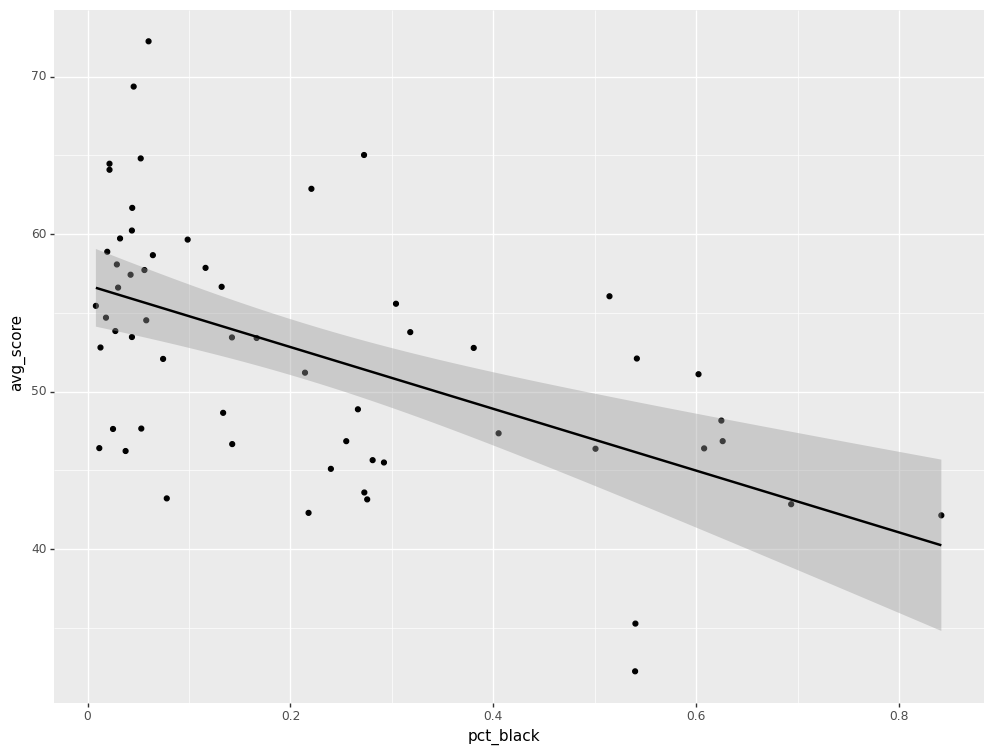

<ggplot: (8734259499096)>

In [206]:
(
    ggplot(CD_joined, aes(x='pct_black', y='avg_score'))
    + geom_point()
    + geom_smooth(method = "lm")
)

In [207]:
plot_dat = CD_joined.melt(id_vars = ["boro_cd", "avg_score"], value_vars = ["poverty_decile", "black_decile", "hispanic_decile","severe_burden_decile"])
plot_dat2 = plot_dat.groupby(["value", "variable"]).agg(avg_score = ("avg_score", "mean")).reset_index()

/opt/conda/envs/HousingNavigatorMA/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


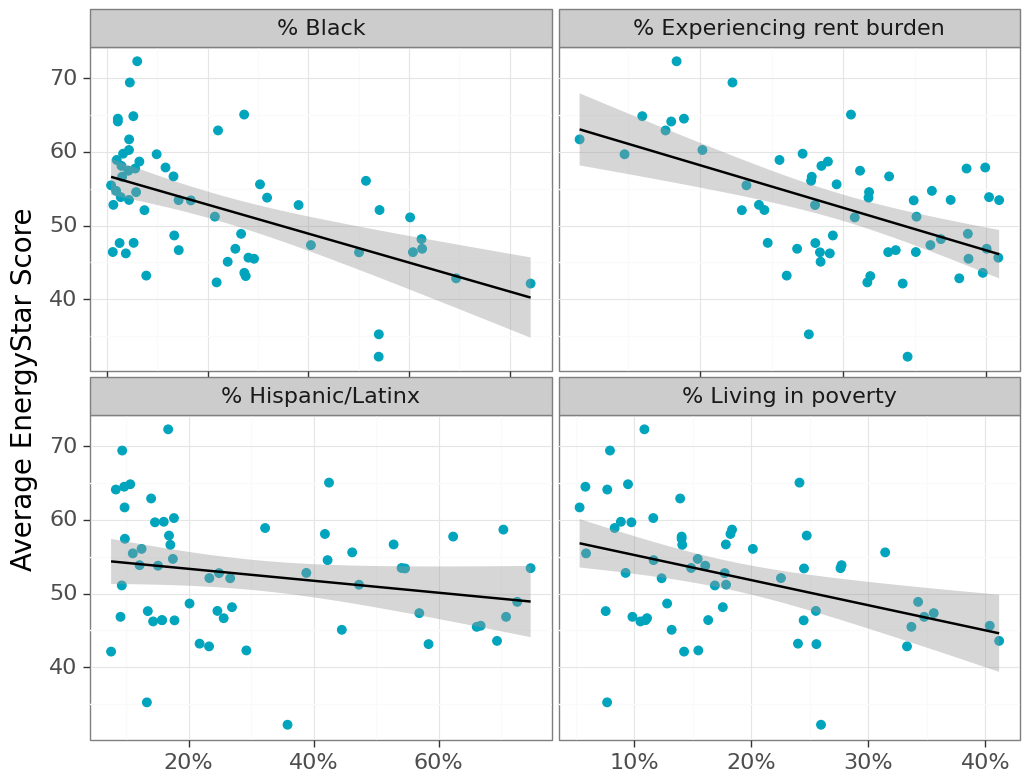

<ggplot: (8734259711576)>

In [208]:
import plotnine as pn
pn.options.figure_size = (12, 9) 

plot_dat = (CD_joined
            .rename({"pct_black" : "% Black",
                    "pct_hispanic": "% Hispanic/Latinx",
                    "pct_in_poverty" : "% Living in poverty",
                    "pct_rent_burden" : "% Experiencing rent burden"}, axis = 1)
            .melt(id_vars = ["boro_cd", "avg_score"], value_vars = ["% Black", "% Hispanic/Latinx", "% Living in poverty", "% Experiencing rent burden"])
            )

(
    ggplot(plot_dat, aes(x='value', y='avg_score'))
    + geom_point(size = 3, color = "#00a5bd")
    + geom_smooth(method = "lm")
    + facet_wrap("variable", scales = "free_x") 
    + scale_x_continuous(labels = lambda l: ["%d%%" % (v * 100) for v in l])
    + labs(x = "", y = "Average EnergyStar Score") 
    + theme(figure_size=(12, 8)) 
    + theme_bw(base_size = 20)
)

In [209]:
CD_joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 59 entries, 0 to 58
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   boro_cd                 59 non-null     int64   
 1   shape_area              59 non-null     object  
 2   shape_leng              59 non-null     object  
 3   geometry                59 non-null     geometry
 4   borough                 59 non-null     object  
 5   cd_neighborhoods        59 non-null     object  
 6   html_names              59 non-null     object  
 7   pct_overcrowding        59 non-null     float64 
 8   pct_rent_burden         59 non-null     float64 
 9   pct_severe_rent_burden  59 non-null     float64 
 10  pct_black               59 non-null     float64 
 11  pct_hispanic            59 non-null     float64 
 12  pct_in_poverty          59 non-null     float64 
 13  avg_score               59 non-null     float64 
 14  avg_sqft            

In [210]:
base_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)

folium.Choropleth(
    geo_data=CD_joined,
    data=CD_joined,
    columns=["boro_cd", "avg_score"],
    key_on="feature.properties.boro_cd",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=1,
    legend_name="avg_score",
    reset=True,
).add_to(base_map)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    CD_joined,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['html_names','score_rounded', "rank"],
        aliases=['Neighborhoods: ','Average EnergyStar Score: ', "Rank within city: "],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)


base_map.add_child(NIL)
base_map.keep_in_front(NIL)
folium.LayerControl().add_to(base_map)
base_map

In [211]:
base_map.save("html/energystar_map.html")

In [212]:
CD_joined[["rank", "avg_score", "boro_cd", "cd_neighborhoods", "pct_in_poverty", "pct_black"]].sort_values('rank')

rank  avg_score  boro_cd                     cd_neighborhoods  \
32   1.0  72.242925      107           West Side, Upper West Side   
26   2.0  69.368000      106          Stuyvesant Town, Turtle Bay   
22   3.0  65.024306      109     Manhattanville, Hamilton Heights   
25   4.0  64.807692      105            Midtown Business District   
24   5.0  64.470339      108                      Upper East Side   
16   6.0  64.086957      102              Greenwich Village, Soho   
49   7.0  62.877698      302        Brooklyn Heights, Fort Greene   
1    8.0  61.666667      101           Battery Park City, Tribeca   
31   9.0  60.228346      104                     Chelsea, Clinton   
47  10.0  59.724771      406              Forest Hills, Rego Park   
17  11.0  59.651515      306          Park Slope, Carroll Gardens   
27  12.0  58.879195      402                  Sunnyside, Woodside   
41  13.0  58.663480      112           Washington Heights, Inwood   
18  14.0  58.074074      307         Sunset Park, Windsor Terrace   
9   15.0  57.857143      313         Coney Island, Brighton Beach   
38  16.0  57.718563      403        Jackson Heights, North Corona   
35  17.0  57.421488      315      Sheepshead Bay, Gerritsen Beach   
6   18.0  56.653992      208  Riverdale, Kingsbridge, Marble Hill   
11  19.0  56.603659      310             Bay Ridge, Dyker Heights   
0   20.0  56.053476      308                  Crown Heights North   
36  21.0  55.578947      111                          East Harlem   
58  22.0  55.444444      503    Tottenville, Woodrow, Great Kills   
5   23.0  54.694215      407                Flushing, Bay Terrace   
55  24.0  54.527778      409             Woodhaven, Richmond Hill   
34  25.0  53.845833      312          Borough Park, Ocean Parkway   
33  26.0  53.774545      314                    Flatbush, Midwood   
46  27.0  53.464912      404               Elmhurst, South Corona   
8   28.0  53.440329      207       Bedford Park, Norwood, Fordham   
51  29.0  53.403846      304                             Bushwick   
12  30.0  52.800000      405         Ridgewood, Glendale, Maspeth   
2   31.0  52.773810      414         The Rockaways, Broad Channel   
40  32.0  52.100000      110                       Central Harlem   
37  33.0  52.075581      401            Astoria, Long Island City   
45  34.0  51.201389      211    Pelham Pkwy, Morris Park, Laconia   
56  35.0  51.103604      309         Crown Heights South, Wingate   
53  36.0  48.876106      202                Hunts Point, Longwood   
14  37.0  48.651786      408             Fresh Meadows, Briarwood   
21  38.0  48.159664      212            Wakefield, Williamsbridge   
39  39.0  47.652850      301             Williamsburg, Greenpoint   
42  40.0  47.627451      411     Bayside, Douglaston, Little Neck   
19  41.0  47.351562      203        Morrisania, Crotona Park East   
30  42.0  46.853659      318                  Canarsie, Flatlands   
7   43.0  46.851282      205   University Hts., Fordham, Mt. Hope   
13  44.0  46.666667      410             Ozone Park, Howard Beach   
10  45.0  46.409836      311             Bensonhurst, Bath Beach    
29  46.0  46.394495      412          Jamaica, St. Albans, Hollis   
50  47.0  46.371429      303                   Bedford Stuyvesant   
57  48.0  46.227273      502         New Springville, South Beach   
20  49.0  45.646667      206                East Tremont, Belmont   
3   50.0  45.498708      204        Highbridge, Concourse Village   
28  51.0  45.095238      210   Throgs Nk., Co-op City, Pelham Bay   
52  52.0  43.594059      201     Melrose, Mott Haven, Port Morris   
48  53.0  43.219048      103           Lower East Side, Chinatown   
44  54.0  43.154839      209               Soundview, Parkchester   
23  55.0  42.849315      316              Brownsville, Ocean Hill   
4   56.0  42.300000      501             Stapleton, Port Richmond   
15  57.0  42.142105      317       East Flatbush, Rugby, Farragut   
43

In [213]:
buildings_CD["apt_size"] = pd.cut(buildings_CD["sqft_per_unit"], [0, 1000, 1500, 1000000])
CD_joined["apt_size"] = pd.cut(buildings_CD["sqft_per_unit"], [0, 650, 1000, 1000000])
buildings_CD["apt_size_q"] = pd.qcut(buildings_CD["sqft_per_unit"], 4)

In [214]:
buildings_CD["B"] = buildings_CD["boro_cd"].astype(str).str.slice(0,1)
buildings_CD.groupby("B").agg(avg = ("EnergyStar", "mean"))

avg
B           
1  62.288014
2  48.907563
3  52.272727
4  53.880435
5  44.549451

In [216]:
buildings_CD["apt_size_q"]

0           (826.364, 950.0]
1           (826.364, 950.0]
2          (20.769, 826.364]
3       (1091.446, 8290.833]
4       (1091.446, 8290.833]
                ...         
9208       (950.0, 1091.446]
9209       (950.0, 1091.446]
9210       (20.769, 826.364]
9211       (20.769, 826.364]
9212       (20.769, 826.364]
Name: apt_size_q, Length: 9213, dtype: category
Categories (4, interval[float64, right]): [(20.769, 826.364] < (826.364, 950.0] < (950.0, 1091.446] < (1091.446, 8290.833]]

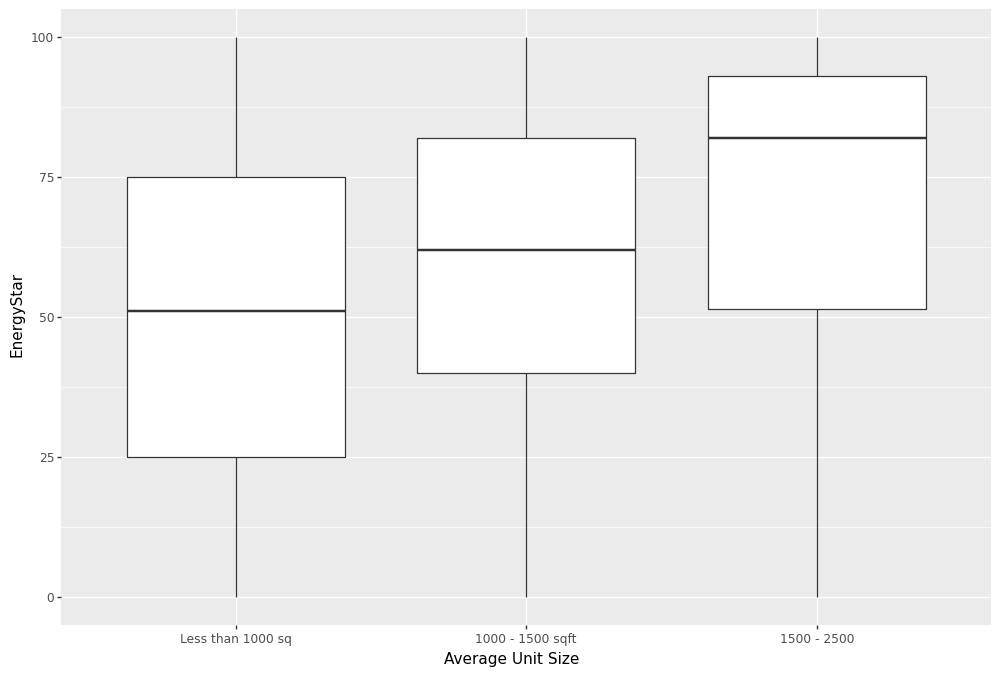

<ggplot: (8734267501593)>

In [217]:
(
    ggplot(buildings_CD, aes(x='apt_size', y='EnergyStar'))
    + geom_boxplot()
    + scale_x_discrete(labels = ["Less than 1000 sq", "1000 - 1500 sqft", "1500 - 2500"])
    + labs(x = "Average Unit Size")
    + theme(figure_size=(12, 8)) 
)


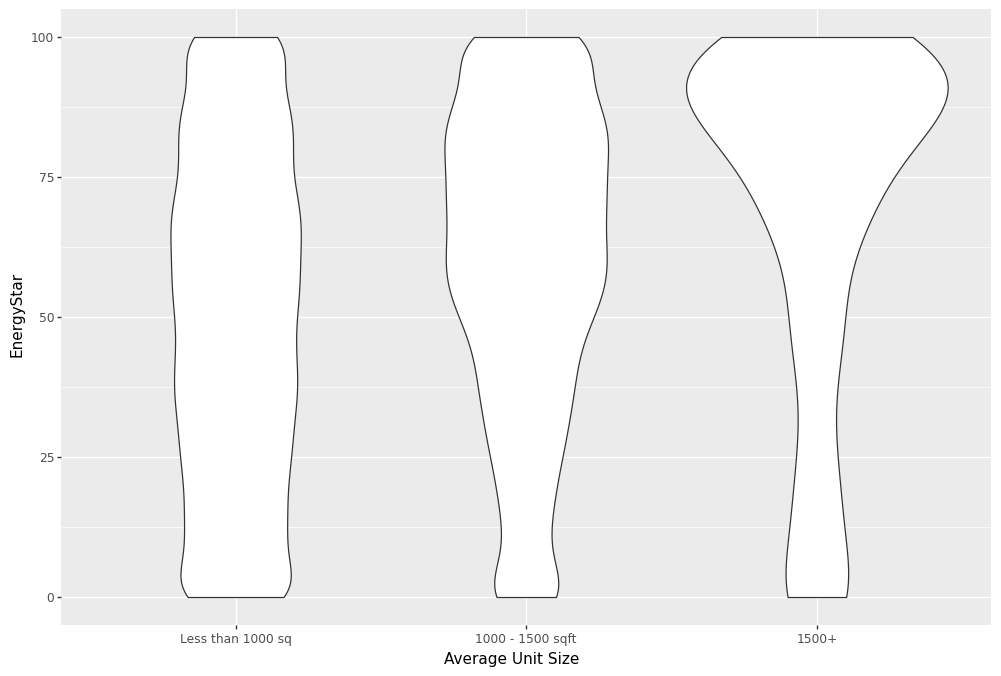

<ggplot: (8734259717726)>

In [218]:
(
    ggplot(buildings_CD, aes(x='apt_size', y='EnergyStar'))
    + geom_violin()
    + scale_x_discrete(labels = ["Less than 1000 sq", "1000 - 1500 sqft", "1500+"])
    + labs(x = "Average Unit Size")
    + theme(figure_size=(12, 8)) 
)

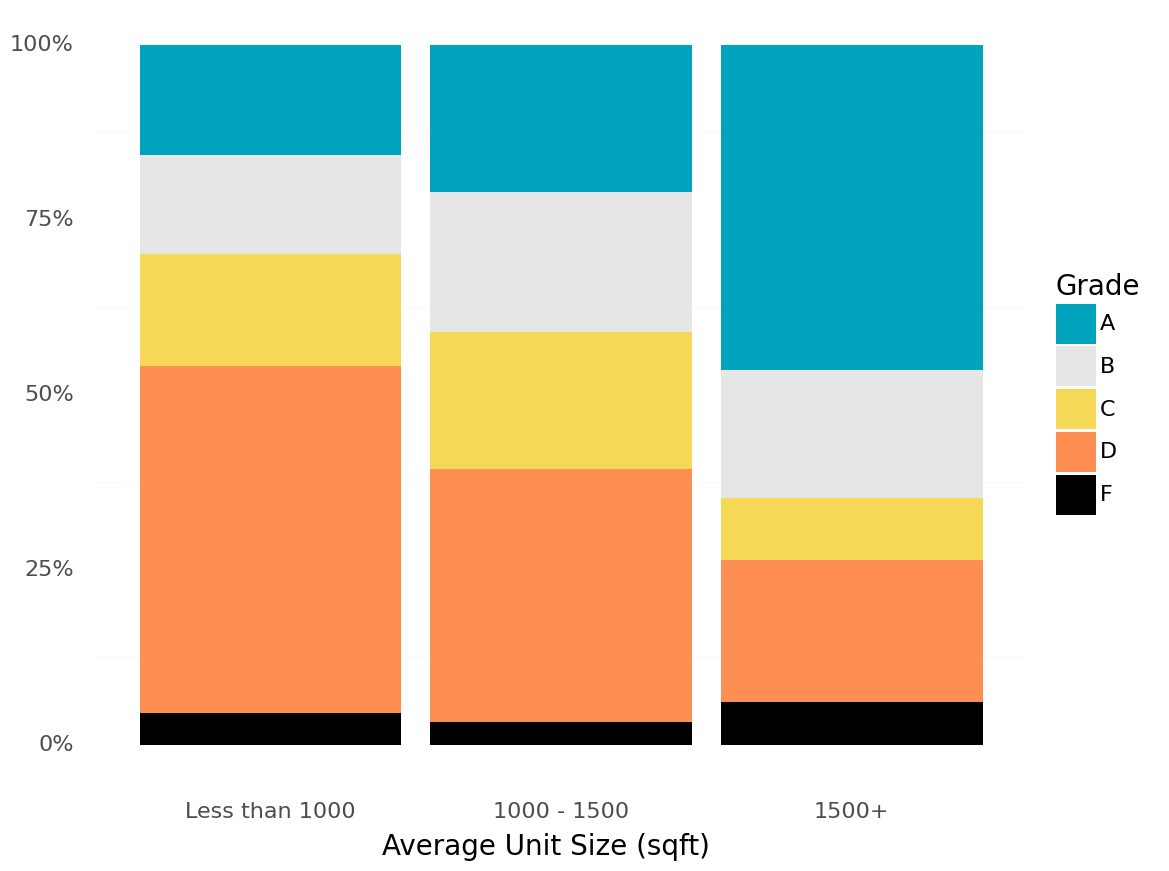

<ggplot: (8734262868914)>

In [219]:
from mizani.formatters import percent_format

(
    ggplot(buildings_CD, aes(x='apt_size', fill='LetterGrad', y =1))
    + geom_bar(position = "fill", stat = "identity")
    + scale_x_discrete(labels = ["Less than 1000", "1000 - 1500", "1500+"])
    + scale_fill_manual(name = "Grade", values = ["#00a5bd", "#e6e6e6", "#f5d855", "#ff8e52", "#000000"])  
    + labs(x = "Average Unit Size (sqft)")
    + theme_minimal(base_size = 20) 
    + theme(figure_size=(12, 10), panel_grid_major=element_blank(),) 
    + labs(y = "") 
    + scale_y_continuous(labels=percent_format())
)

In [159]:
CD_joined[[ "avg_score", "pct_in_poverty", "pct_black", "pct_hispanic", "pct_rent_burden", "avg_sqft"]].corr()

avg_score  pct_in_poverty  pct_black  pct_hispanic  \
avg_score         1.000000       -0.395198  -0.534251     -0.212059   
pct_in_poverty   -0.395198        1.000000   0.312851      0.647237   
pct_black        -0.534251        0.312851   1.000000     -0.034471   
pct_hispanic     -0.212059        0.647237  -0.034471      1.000000   
pct_rent_burden  -0.523458        0.663984   0.281238      0.574974   
avg_sqft          0.448849       -0.206462  -0.188217     -0.220871   

                 pct_rent_burden  avg_sqft  
avg_score              -0.523458  0.448849  
pct_in_poverty          0.663984 -0.206462  
pct_black               0.281238 -0.188217  
pct_hispanic            0.574974 -0.220871  
pct_rent_burden         1.000000 -0.495918  
avg_sqft               -0.495918  1.000000